In [138]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [139]:
WINDOW_LENGTH = 256  # data window
STRIDE = 128        # stride
BATCH_SIZE = 64  # batch
EPOCHS = 100  # epoch
LEARNING_RATE = 0.0001  # lr
PROJ_DIM = 128  # embedding dimension

In [140]:
datapath = "../../../data/SisFall_Dataset/" 

In [141]:
'''
        Each file contains nine columns and a different number of rows depending on the test length.
        
        1st column is the acceleration data in the X axis measured by the sensor ADXL345.
        2nd column is the acceleration data in the Y axis measured by the sensor ADXL345.
        3rd column is the acceleration data in the Z axis measured by the sensor ADXL345.

        4th column is the rotation data in the X axis measured by the sensor ITG3200.
        5th column is the rotation data in the Y axis measured by the sensor ITG3200.
        6th column is the rotation data in the Z axis measured by the sensor ITG3200.

        7th column is the acceleration data in the X axis measured by the sensor MMA8451Q.
        8th column is the acceleration data in the Y axis measured by the sensor MMA8451Q.
        9th column is the acceleration data in the Z axis measured by the sensor MMA8451Q.
        
        Data are in bits with the following characteristics:

        ADXL345:
        Resolution: 13 bits
        Range: +-16g

        ITG3200
        Resolution: 16 bits
        Range: +-2000°/s

        MMA8451Q:
        Resolution: 14 bits
        Range: +-8g
'''

'\n        Each file contains nine columns and a different number of rows depending on the test length.\n        \n        1st column is the acceleration data in the X axis measured by the sensor ADXL345.\n        2nd column is the acceleration data in the Y axis measured by the sensor ADXL345.\n        3rd column is the acceleration data in the Z axis measured by the sensor ADXL345.\n\n        4th column is the rotation data in the X axis measured by the sensor ITG3200.\n        5th column is the rotation data in the Y axis measured by the sensor ITG3200.\n        6th column is the rotation data in the Z axis measured by the sensor ITG3200.\n\n        7th column is the acceleration data in the X axis measured by the sensor MMA8451Q.\n        8th column is the acceleration data in the Y axis measured by the sensor MMA8451Q.\n        9th column is the acceleration data in the Z axis measured by the sensor MMA8451Q.\n        \n        Data are in bits with the following characteristics:\

In [142]:
adl_activities = [f'D{str(i).zfill(2)}' for i in range(1, 20)]  # D01-D19
fall_activities = [f'F{str(i).zfill(2)}' for i in range(1, 16)]  # F01-F15

label2id = {act: 0 for act in adl_activities}
label2id.update({act: 1 for act in fall_activities})

adult_subjects = [f'SA{str(i).zfill(2)}' for i in range(1, 24)]  # SA01-SA23
elderly_subjects = [f'SE{str(i).zfill(2)}' for i in range(1, 16)]  # SE01-SE15

train_sa = adult_subjects[:16]    # 16 subjects
val_sa = adult_subjects[16:19]    # 3 subjects
test_sa = adult_subjects[19:]     # 4 subjects

train_se = elderly_subjects[:10]  # 10 subjects
val_se = elderly_subjects[10:12]  # 2 subjects
test_se = elderly_subjects[12:]   # 3 subjects

train_split = train_sa + train_se
val_split = val_sa + val_se
test_split = test_sa + test_se

In [143]:
def read_sensor_file(filepath) :
   """
       first 6 columns : ADXL345 acc + ITG3200 gyro
   """
   with open(filepath, 'r') as file:
       content = file.read()

   content = content.replace(' ', '')  # delete blank
   rows = []

   for line in content.split(';\n'): 
       if line.strip():
           try:
               values = [float(x) for x in line.split(',')[:6]]
               rows.append(values)
           except (ValueError, IndexError):
               continue

   return np.array(rows)

In [144]:
def split_sequences(data, labels, 
                    window_length=WINDOW_LENGTH, 
                    stride=STRIDE,
                    clean=True):
    idx = 0
    endidx = len(data)
    windows = []
    window_labels = []
    
    while idx < endidx - window_length:
        data_segment = data[idx:idx+window_length].T
        
        if clean and len(np.unique(labels[idx:idx + window_length])) > 1:
            pass
        else:
            windows.append(data_segment)
            window_labels.append(labels[idx+window_length])
        
        idx += stride
    
    if len(windows) == 0:
        return None, None
    
    return np.stack(windows), np.asarray(window_labels)

In [145]:
'''
   TRAIN DATA PREPARING PART
   ONLY "ADL"
'''
train_data_normal = []  
train_labels_normal = [] 

for subject in tqdm(train_split):  
   subject_dir = os.path.join(datapath, subject)
   
   if subject.startswith('SE') and subject != 'SE06':
       continue
       
   for activity in adl_activities:
       activity_pattern = os.path.join(subject_dir, f"{activity}*.txt")
       activity_files = glob.glob(activity_pattern)
       
       for file_path in activity_files:
           try:
               raw_data = read_sensor_file(file_path)
               if raw_data is not None and raw_data.shape[1] == 6:
                   sensor_data = raw_data
                   activity_labels = np.full(len(sensor_data), label2id[activity])
                   
                   windows_data, windows_labels = split_sequences(
                       sensor_data, activity_labels, 
                       WINDOW_LENGTH, STRIDE
                   )
                   
                   if windows_data is not None and len(windows_data) > 0:
                       train_data_normal.append(windows_data)
                       train_labels_normal.append(windows_labels)
                   
           except Exception as e: 
               print(f"Error processing file {file_path}: {e}")
               
train_data_normal = np.concatenate(train_data_normal, axis=0)
train_labels_normal = np.concatenate(train_labels_normal)

print (f"# of windows: {len(train_data_normal)}")
print (f"data shape: {train_data_normal.shape}")
print (f"labels shape: {train_labels_normal.shape}")
unique_labels, counts = np.unique(train_labels_normal, return_counts=True)
print (dict(zip(unique_labels, counts)))

100%|███████████████████████████████████████████| 26/26 [00:16<00:00,  1.59it/s]


# of windows: 37570
data shape: (37570, 6, 256)
labels shape: (37570,)
{0: 37570}


In [146]:
'''
   TEST DATA PREPARING PART
   ADL + FALL
'''
test_data = []
test_labels = []

for subject in tqdm(test_split):
   subject_dir = os.path.join(datapath, subject)
   
   is_elderly = subject.startswith('SE')
   
   if not (is_elderly and subject != 'SE06'): 
       for activity in adl_activities:
           activity_pattern = os.path.join(subject_dir, f"{activity}*.txt")
           activity_files = glob.glob(activity_pattern)
           
           for file_path in activity_files:
               try:
                   raw_data = read_sensor_file(file_path)
                   if raw_data is not None and raw_data.shape[1] == 6:
                       sensor_data = raw_data
                       activity_labels = np.full(len(sensor_data), label2id[activity])
                       
                       windows_data, windows_labels = split_sequences(
                           sensor_data, activity_labels,
                           WINDOW_LENGTH, STRIDE
                       )
                       
                       if windows_data is not None and len(windows_data) > 0:
                           test_data.append(windows_data)
                           test_labels.append(windows_labels)
                           
               except Exception as e:
                   print(f"Error processing file {file_path}: {e}")
   
   if not is_elderly or subject == 'SE06':
       for activity in fall_activities:
           activity_pattern = os.path.join(subject_dir, f"{activity}*.txt")
           activity_files = glob.glob(activity_pattern)
           
           for file_path in activity_files:
               try:
                   raw_data = read_sensor_file(file_path)
                   if raw_data is not None and raw_data.shape[1] == 6:
                       sensor_data = raw_data
                       activity_labels = np.full(len(sensor_data), label2id[activity])
                       
                       windows_data, windows_labels = split_sequences(
                           sensor_data, activity_labels,
                           WINDOW_LENGTH, STRIDE
                       )
                       
                       if windows_data is not None and len(windows_data) > 0:
                           test_data.append(windows_data)
                           test_labels.append(windows_labels)
                           
               except Exception as e:
                   print(f"Error processing file {file_path}: {e}")

test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels)

print (f"# of windows: {len(test_data)}")
print (f"data shape: {test_data.shape}")
print (f"labels shape: {test_labels.shape}")
unique_labels, counts = np.unique(test_labels, return_counts=True)
print(dict(zip(unique_labels, counts)))

100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.07it/s]

# of windows: 15319
data shape: (15319, 6, 256)
labels shape: (15319,)
{0: 8764, 1: 6555}


In [147]:
train_data_shape = train_data_normal.shape
test_data_shape = test_data.shape

train_data_2d = train_data_normal.reshape(-1, train_data_normal.shape[-1])
test_data_2d = test_data.reshape(-1, test_data.shape[-1])

scaler = StandardScaler()
train_data_2d = scaler.fit_transform(train_data_2d)
test_data_2d = scaler.transform(test_data_2d)

train_data_normal = train_data_2d.reshape(train_data_shape)
test_data = test_data_2d.reshape(test_data_shape)

In [148]:
train_acc_normal = train_data_normal[..., :3] 
train_gyro_normal = train_data_normal[..., 3:]  
# (x, y, z)

test_acc = test_data[..., :3]  
test_gyro = test_data[..., 3:] 

train_dataset = tf.data.Dataset.from_tensor_slices((train_acc_normal, train_gyro_normal))
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    ((test_acc, test_gyro), test_labels)
).batch(BATCH_SIZE)

print (f"train data - accel shape: {train_acc_normal.shape}")
print (f"train data - gyro shape: {train_gyro_normal.shape}")
print (f"test data - accel shape: {test_acc.shape}")
print (f"test data - gyro shape: {test_gyro.shape}")
print (f"# of training batches: {len(train_dataset)}")
print (f"# of test batches: {len(test_dataset)}")

train data - accel shape: (37570, 6, 3)
train data - gyro shape: (37570, 6, 253)
test data - accel shape: (15319, 6, 3)
test data - gyro shape: (15319, 6, 253)
# of training batches: 588
# of test batches: 240


------

In [149]:
class Encoder(Model):
    def __init__(self, in_feat, out_feat, num_encoders=1, use_skip=True):
        super(Encoder, self).__init__()
        self.use_skip = use_skip
        self.num_encoders = num_encoders
        
        for i in range(num_encoders):
            setattr(self, f'conv1_{i}', layers.Conv1D(filters=out_feat*3, 
                                                      kernel_size=7, padding='same', 
                                                      activation='relu'))
            setattr(self, f'maxpool1_{i}', layers.MaxPooling1D(pool_size=2, padding='same'))
            setattr(self, f'conv2_{i}', layers.Conv1D(filters=out_feat*2, 
                                                      kernel_size=5, padding='same', 
                                                      activation='relu'))
            setattr(self, f'maxpool2_{i}', layers.MaxPooling1D(pool_size=2, padding='same'))
            setattr(self, f'conv3_{i}', layers.Conv1D(filters=out_feat*1, 
                                                      kernel_size=3, padding='same', 
                                                      activation='relu'))
    
    def call(self, x, training=False):
        for i in range(self.num_encoders):
            if self.use_skip and i > 0:
                identity = x
            
            x = getattr(self, f'conv1_{i}')(x)
            x = getattr(self, f'maxpool1_{i}')(x)
            x = getattr(self, f'conv2_{i}')(x)
            x = getattr(self, f'maxpool2_{i}')(x)
            x = getattr(self, f'conv3_{i}')(x)
            
            if self.use_skip and i > 0:
                x = x + identity
        
        return tf.reduce_mean(x, axis=1)

In [150]:
class CAGE(Model):
    def __init__(self, n_feat=6, proj_dim=128):
        super(CAGE, self).__init__()
        self.proj_dim = proj_dim
        
        self.enc_A = Encoder(n_feat, 64)
        self.enc_G = Encoder(n_feat, 64)
        
        if self.proj_dim > 0:
            self.proj_A = layers.Dense(proj_dim, use_bias=False)
            self.proj_G = layers.Dense(proj_dim, use_bias=False)
        
#         self.temperature = tf.Variable(0.1, trainable=True)
        self.temperature = tf.constant(0.1)
    
    def call(self, x_accel, x_gyro, return_feat=False, training=False):
        f_accel = self.enc_A(x_accel, training=training)
        f_gyro = self.enc_G(x_gyro, training=training)
        
        if self.proj_dim > 0:
            e_accel = self.proj_A(f_accel)
            e_gyro = self.proj_G(f_gyro)
        else:
            e_accel = f_accel
            e_gyro = f_gyro
        
        e_accel = tf.math.l2_normalize(e_accel, axis=1)
        e_gyro = tf.math.l2_normalize(e_gyro, axis=1)
        
        sim_matrix = tf.matmul(e_accel, e_gyro, transpose_b=True) / self.temperature
        
        if return_feat:
            return sim_matrix, (e_accel, e_gyro)
        
        return sim_matrix

In [151]:
model = CAGE(proj_dim=PROJ_DIM)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE
)

In [152]:
# @tf.function
# def contrastive_loss(logits):
#     """NT-Xent Loss"""
#     batch_size = tf.shape(logits)[0]
    
#     labels = tf.eye(batch_size) # diagonal matrix 
    
#     '''
#         loss calculating using CrossEntropy
#     '''
#     loss = tf.keras.losses.categorical_crossentropy(
#         labels, 
#         tf.nn.softmax(logits, axis=-1), 
#         from_logits=False
#     )
    
#     return tf.reduce_mean(loss)

def contrastive_loss(sim_matrix):
    epsilon = 1e-8
    sim_matrix = sim_matrix + epsilon
    
    batch_size = tf.shape(sim_matrix)[0]
    
    labels = tf.eye(batch_size)
    
    loss_1 = tf.keras.losses.categorical_crossentropy(
        labels,
        tf.nn.softmax(sim_matrix, axis=1),
        from_logits=False
    )
    
    loss_2 = tf.keras.losses.categorical_crossentropy(
        labels,
        tf.nn.softmax(sim_matrix, axis=0),
        from_logits=False
    )
    
    total_loss = (loss_1 + loss_2) / 2
    return tf.reduce_mean(total_loss)

In [153]:
@tf.function
def train_step(model, optimizer, x_accel, x_gyro):
    with tf.GradientTape() as tape:
        sim_matrix, (e_accel, e_gyro) = model(x_accel, x_gyro, return_feat=True, training=True)
        loss = contrastive_loss(sim_matrix)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    gradients = [tf.clip_by_norm(g, 0.5) if g is not None else g for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

----

In [154]:
print (train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 6, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6, 253), dtype=tf.float64, name=None))>


In [155]:
train_losses = []
best_loss = float('inf')

for epoch in range(EPOCHS):
    epoch_losses = []
    
    for acc_batch, gyro_batch in tqdm(train_dataset, desc=f'Epoch {epoch + 1}/{EPOCHS}'):
        loss = train_step(model, optimizer, acc_batch, gyro_batch)  
        epoch_losses.append(loss.numpy())
    
    avg_loss = np.mean(epoch_losses)
    train_losses.append(avg_loss)
    
    print (f"mean value of loss : {avg_loss:.4f}")
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        print (f"best loss achieved : {best_loss:.4f}")

        
print("END THE LEARNING")
print(f"final best loss: {best_loss:.4f}")

Epoch 1/100: 100%|████████████████████████████| 588/588 [00:14<00:00, 40.98it/s]


mean value of loss : 2.8906
best loss achieved : 2.8906


Epoch 2/100: 100%|████████████████████████████| 588/588 [00:12<00:00, 46.07it/s]


mean value of loss : 2.1060
best loss achieved : 2.1060


Epoch 3/100: 100%|████████████████████████████| 588/588 [00:12<00:00, 45.45it/s]


mean value of loss : 1.8527
best loss achieved : 1.8527


Epoch 4/100: 100%|████████████████████████████| 588/588 [00:13<00:00, 42.33it/s]


mean value of loss : 1.7047
best loss achieved : 1.7047


Epoch 5/100: 100%|████████████████████████████| 588/588 [00:15<00:00, 38.73it/s]


mean value of loss : 1.5933
best loss achieved : 1.5933


Epoch 6/100: 100%|████████████████████████████| 588/588 [00:16<00:00, 35.74it/s]


mean value of loss : 1.4942
best loss achieved : 1.4942


Epoch 7/100: 100%|████████████████████████████| 588/588 [00:15<00:00, 36.84it/s]


mean value of loss : 1.3837
best loss achieved : 1.3837


Epoch 8/100: 100%|████████████████████████████| 588/588 [00:17<00:00, 34.13it/s]


mean value of loss : 1.2833
best loss achieved : 1.2833


Epoch 9/100: 100%|████████████████████████████| 588/588 [00:15<00:00, 38.32it/s]


mean value of loss : 1.2126
best loss achieved : 1.2126


Epoch 10/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 43.17it/s]


mean value of loss : 1.1479
best loss achieved : 1.1479


Epoch 11/100: 100%|███████████████████████████| 588/588 [00:14<00:00, 41.66it/s]


mean value of loss : 1.0967
best loss achieved : 1.0967


Epoch 12/100: 100%|███████████████████████████| 588/588 [00:14<00:00, 41.32it/s]


mean value of loss : 1.0622
best loss achieved : 1.0622


Epoch 13/100: 100%|███████████████████████████| 588/588 [00:14<00:00, 41.39it/s]


mean value of loss : 1.0257
best loss achieved : 1.0257


Epoch 14/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 44.78it/s]


mean value of loss : 1.0043
best loss achieved : 1.0043


Epoch 15/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 43.75it/s]


mean value of loss : 0.9668
best loss achieved : 0.9668


Epoch 16/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 42.82it/s]


mean value of loss : 0.9572
best loss achieved : 0.9572


Epoch 17/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 44.85it/s]


mean value of loss : 0.9229
best loss achieved : 0.9229


Epoch 18/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 46.04it/s]


mean value of loss : 0.8964
best loss achieved : 0.8964


Epoch 19/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 43.02it/s]


mean value of loss : 0.8883
best loss achieved : 0.8883


Epoch 20/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 44.73it/s]


mean value of loss : 0.8640
best loss achieved : 0.8640


Epoch 21/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 42.22it/s]


mean value of loss : 0.8461
best loss achieved : 0.8461


Epoch 22/100: 100%|███████████████████████████| 588/588 [00:15<00:00, 37.27it/s]


mean value of loss : 0.8455
best loss achieved : 0.8455


Epoch 23/100: 100%|███████████████████████████| 588/588 [00:17<00:00, 34.20it/s]


mean value of loss : 0.8142
best loss achieved : 0.8142


Epoch 24/100: 100%|███████████████████████████| 588/588 [00:15<00:00, 38.46it/s]


mean value of loss : 0.8113
best loss achieved : 0.8113


Epoch 25/100: 100%|███████████████████████████| 588/588 [00:15<00:00, 36.77it/s]


mean value of loss : 0.7980
best loss achieved : 0.7980


Epoch 26/100: 100%|███████████████████████████| 588/588 [00:15<00:00, 36.82it/s]


mean value of loss : 0.7747
best loss achieved : 0.7747


Epoch 27/100: 100%|███████████████████████████| 588/588 [00:14<00:00, 39.70it/s]


mean value of loss : 0.7713
best loss achieved : 0.7713


Epoch 28/100: 100%|███████████████████████████| 588/588 [00:15<00:00, 38.02it/s]


mean value of loss : 0.7564
best loss achieved : 0.7564


Epoch 29/100: 100%|███████████████████████████| 588/588 [00:14<00:00, 39.98it/s]


mean value of loss : 0.7413
best loss achieved : 0.7413


Epoch 30/100: 100%|███████████████████████████| 588/588 [00:14<00:00, 40.86it/s]


mean value of loss : 0.7292
best loss achieved : 0.7292


Epoch 31/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 43.36it/s]


mean value of loss : 0.7176
best loss achieved : 0.7176


Epoch 32/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 42.11it/s]


mean value of loss : 0.7133
best loss achieved : 0.7133


Epoch 33/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 44.87it/s]


mean value of loss : 0.6927
best loss achieved : 0.6927


Epoch 34/100: 100%|███████████████████████████| 588/588 [00:14<00:00, 41.28it/s]


mean value of loss : 0.7017


Epoch 35/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 43.79it/s]


mean value of loss : 0.6872
best loss achieved : 0.6872


Epoch 36/100: 100%|███████████████████████████| 588/588 [00:14<00:00, 39.93it/s]


mean value of loss : 0.6797
best loss achieved : 0.6797


Epoch 37/100: 100%|███████████████████████████| 588/588 [00:14<00:00, 41.27it/s]


mean value of loss : 0.6682
best loss achieved : 0.6682


Epoch 38/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 43.43it/s]


mean value of loss : 0.6763


Epoch 39/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 48.65it/s]


mean value of loss : 0.6547
best loss achieved : 0.6547


Epoch 40/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 44.26it/s]


mean value of loss : 0.6467
best loss achieved : 0.6467


Epoch 41/100: 100%|███████████████████████████| 588/588 [00:14<00:00, 41.75it/s]


mean value of loss : 0.6329
best loss achieved : 0.6329


Epoch 42/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 43.98it/s]


mean value of loss : 0.6404


Epoch 43/100: 100%|███████████████████████████| 588/588 [00:14<00:00, 40.55it/s]


mean value of loss : 0.6313
best loss achieved : 0.6313


Epoch 44/100: 100%|███████████████████████████| 588/588 [00:14<00:00, 40.28it/s]


mean value of loss : 0.6182
best loss achieved : 0.6182


Epoch 45/100: 100%|███████████████████████████| 588/588 [00:16<00:00, 36.72it/s]


mean value of loss : 0.5980
best loss achieved : 0.5980


Epoch 46/100: 100%|███████████████████████████| 588/588 [00:15<00:00, 38.53it/s]


mean value of loss : 0.6040


Epoch 47/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 42.88it/s]


mean value of loss : 0.6077


Epoch 48/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 45.38it/s]


mean value of loss : 0.6011


Epoch 49/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 43.86it/s]


mean value of loss : 0.6047


Epoch 50/100: 100%|███████████████████████████| 588/588 [00:14<00:00, 40.50it/s]


mean value of loss : 0.5822
best loss achieved : 0.5822


Epoch 51/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 47.11it/s]


mean value of loss : 0.5774
best loss achieved : 0.5774


Epoch 52/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 48.26it/s]


mean value of loss : 0.5913


Epoch 53/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 45.61it/s]


mean value of loss : 0.5701
best loss achieved : 0.5701


Epoch 54/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 42.78it/s]


mean value of loss : 0.5877


Epoch 55/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 47.56it/s]


mean value of loss : 0.5718


Epoch 56/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 46.58it/s]


mean value of loss : 0.5624
best loss achieved : 0.5624


Epoch 57/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 42.94it/s]


mean value of loss : 0.5685


Epoch 58/100: 100%|███████████████████████████| 588/588 [00:11<00:00, 51.71it/s]


mean value of loss : 0.5559
best loss achieved : 0.5559


Epoch 59/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 46.66it/s]


mean value of loss : 0.5680


Epoch 60/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 43.28it/s]


mean value of loss : 0.5576


Epoch 61/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 45.77it/s]


mean value of loss : 0.5776


Epoch 62/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 47.87it/s]


mean value of loss : 0.5319
best loss achieved : 0.5319


Epoch 63/100: 100%|███████████████████████████| 588/588 [00:14<00:00, 41.58it/s]


mean value of loss : 0.5304
best loss achieved : 0.5304


Epoch 64/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 43.74it/s]


mean value of loss : 0.5250
best loss achieved : 0.5250


Epoch 65/100: 100%|███████████████████████████| 588/588 [00:14<00:00, 40.36it/s]


mean value of loss : 0.5226
best loss achieved : 0.5226


Epoch 66/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 45.87it/s]


mean value of loss : 0.5353


Epoch 67/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 42.78it/s]


mean value of loss : 0.5155
best loss achieved : 0.5155


Epoch 68/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 46.14it/s]


mean value of loss : 0.5090
best loss achieved : 0.5090


Epoch 69/100: 100%|███████████████████████████| 588/588 [00:11<00:00, 52.47it/s]


mean value of loss : 0.4969
best loss achieved : 0.4969


Epoch 70/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 43.77it/s]


mean value of loss : 0.5139


Epoch 71/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 45.09it/s]


mean value of loss : 0.4987


Epoch 72/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 45.79it/s]


mean value of loss : 0.5205


Epoch 73/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 44.39it/s]


mean value of loss : 0.4972


Epoch 74/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 45.94it/s]


mean value of loss : 0.4993


Epoch 75/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 45.31it/s]


mean value of loss : 0.4905
best loss achieved : 0.4905


Epoch 76/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 44.97it/s]


mean value of loss : 0.5056


Epoch 77/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 46.17it/s]


mean value of loss : 0.4833
best loss achieved : 0.4833


Epoch 78/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 45.10it/s]


mean value of loss : 0.4876


Epoch 79/100: 100%|███████████████████████████| 588/588 [00:11<00:00, 51.87it/s]


mean value of loss : 0.4898


Epoch 80/100: 100%|███████████████████████████| 588/588 [00:11<00:00, 51.74it/s]


mean value of loss : 0.4672
best loss achieved : 0.4672


Epoch 81/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 42.25it/s]


mean value of loss : 0.4724


Epoch 82/100: 100%|███████████████████████████| 588/588 [00:14<00:00, 41.97it/s]


mean value of loss : 0.4715


Epoch 83/100: 100%|███████████████████████████| 588/588 [00:14<00:00, 39.95it/s]


mean value of loss : 0.4764


Epoch 84/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 43.18it/s]


mean value of loss : 0.4800


Epoch 85/100: 100%|███████████████████████████| 588/588 [00:14<00:00, 41.60it/s]


mean value of loss : 0.4855


Epoch 86/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 47.63it/s]


mean value of loss : 0.4576
best loss achieved : 0.4576


Epoch 87/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 46.89it/s]


mean value of loss : 0.4609


Epoch 88/100: 100%|███████████████████████████| 588/588 [00:11<00:00, 51.28it/s]


mean value of loss : 0.4495
best loss achieved : 0.4495


Epoch 89/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 46.94it/s]


mean value of loss : 0.4674


Epoch 90/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 43.35it/s]


mean value of loss : 0.4748


Epoch 91/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 44.21it/s]


mean value of loss : 0.4641


Epoch 92/100: 100%|███████████████████████████| 588/588 [00:11<00:00, 50.60it/s]


mean value of loss : 0.4428
best loss achieved : 0.4428


Epoch 93/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 45.77it/s]


mean value of loss : 0.4308
best loss achieved : 0.4308


Epoch 94/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 44.70it/s]


mean value of loss : 0.4579


Epoch 95/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 43.12it/s]


mean value of loss : 0.4451


Epoch 96/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 43.67it/s]


mean value of loss : 0.4439


Epoch 97/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 44.07it/s]


mean value of loss : 0.4453


Epoch 98/100: 100%|███████████████████████████| 588/588 [00:13<00:00, 44.88it/s]


mean value of loss : 0.4325


Epoch 99/100: 100%|███████████████████████████| 588/588 [00:12<00:00, 46.10it/s]


mean value of loss : 0.4372


Epoch 100/100: 100%|██████████████████████████| 588/588 [00:12<00:00, 45.91it/s]

mean value of loss : 0.4285
best loss achieved : 0.4285
END THE LEARNING
final best loss: 0.4285


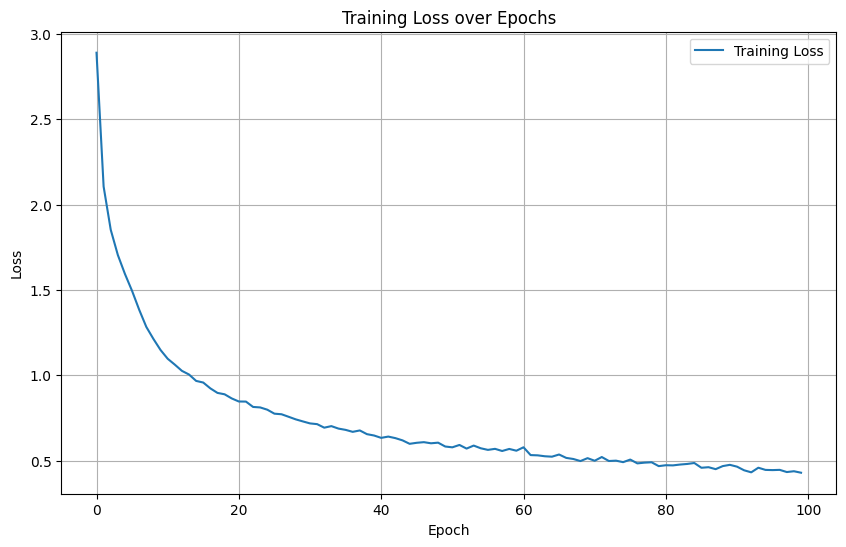

In [156]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

----

In [157]:
def compute_similarity_scores(model, data_loader):
    similarities = []
    labels = []
    
    for (acc_batch, gyro_batch), batch_labels in data_loader:
        # get embeddings
        _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False) 
        # get embedding of accel and gyro
        
        # calculate cosine similarity between paired embeddings
        batch_similarities = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
        
        similarities.extend(batch_similarities.numpy())
        labels.extend(batch_labels.numpy())
    
    return np.array(similarities), np.array(labels)

In [158]:
normal_similarities = []
for acc_batch, gyro_batch in tqdm(train_dataset, desc='Computing normal similarities'):
    # train set embedding -> similarity
    _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False) # <- embedding
    sim = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
    normal_similarities.extend(sim.numpy())

test_similarities = []
test_pred_labels = []
for (acc_batch, gyro_batch), labels in tqdm(test_dataset, desc='Computing test similarities'):
    # test set embedding -> simiilarity
    _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False) # <- embedding
    sim = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
    test_similarities.extend(sim.numpy())
    test_pred_labels.extend(labels.numpy())

Computing test similarities: 100%|████████████| 240/240 [00:04<00:00, 52.17it/s]


In [159]:
def calculate_similarities(model, test_dataset):
    normal_similarities = []
    fall_similarities = []
    
    for (acc_batch, gyro_batch), labels in test_dataset:
        _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False)
        
        sim = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
        
        for sim_score, label in zip(sim.numpy(), labels.numpy()):
            if label == 0:  # normal
                normal_similarities.append(sim_score)
            else:  # fall
                fall_similarities.append(sim_score)
    
    return np.array(normal_similarities), np.array(fall_similarities)

normal_sims, fall_sims = calculate_similarities(model, test_dataset)

print("[ ADL data ]")
print(f"  Mean: {np.mean(normal_sims):.4f}")
print(f"  Std: {np.std(normal_sims):.4f}")
print(f"  Min: {np.min(normal_sims):.4f}")
print(f"  Max: {np.max(normal_sims):.4f}")
for i in range (20) :
    print ('ADL ind', i+1, ':', normal_sims[i])

print ()
print("[ FALL data ]")
print(f"  Mean: {np.mean(fall_sims):.4f}")
print(f"  Std: {np.std(fall_sims):.4f}")
print(f"  Min: {np.min(fall_sims):.4f}")
print(f"  Max: {np.max(fall_sims):.4f}")
for i in range (20) :
    print ('FALL ind', i+1, ':', fall_sims[i])

[ ADL data ]
  Mean: 0.8092
  Std: 0.1694
  Min: -0.5104
  Max: 0.9873
ADL ind 1 : 0.82348233
ADL ind 2 : 0.80410993
ADL ind 3 : 0.89996666
ADL ind 4 : 0.80685186
ADL ind 5 : 0.8040313
ADL ind 6 : 0.9329908
ADL ind 7 : 0.85843146
ADL ind 8 : 0.85680914
ADL ind 9 : 0.90270233
ADL ind 10 : 0.6861911
ADL ind 11 : 0.8501441
ADL ind 12 : 0.9139186
ADL ind 13 : 0.9436889
ADL ind 14 : 0.9149496
ADL ind 15 : 0.8102431
ADL ind 16 : 0.9196624
ADL ind 17 : 0.85825896
ADL ind 18 : 0.8545114
ADL ind 19 : 0.78775734
ADL ind 20 : 0.8777603

[ FALL data ]
  Mean: 0.7974
  Std: 0.1594
  Min: -0.5219
  Max: 0.9800
FALL ind 1 : 0.8781861
FALL ind 2 : 0.8456881
FALL ind 3 : 0.93536776
FALL ind 4 : 0.91352606
FALL ind 5 : 0.7428826
FALL ind 6 : 0.7493977
FALL ind 7 : 0.8467339
FALL ind 8 : 0.7320255
FALL ind 9 : 0.80731595
FALL ind 10 : 0.88609016
FALL ind 11 : 0.8380214
FALL ind 12 : 0.8750088
FALL ind 13 : 0.41145527
FALL ind 14 : 0.7775711
FALL ind 15 : 0.4127715
FALL ind 16 : 0.8014673
FALL ind 17 : 0.

In [160]:
threshold = np.percentile(normal_similarities, 10)

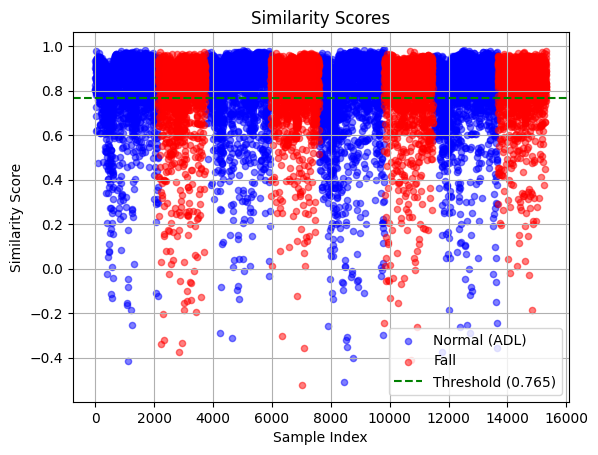

In [161]:
indices = range(len(test_similarities))
plt.scatter([i for i, l in zip(indices, test_pred_labels) if l == 0], 
           [s for s, l in zip(test_similarities, test_pred_labels) if l == 0],
           c='blue', label='Normal (ADL)', alpha=0.5, s=20)
plt.scatter([i for i, l in zip(indices, test_pred_labels) if l == 1],
           [s for s, l in zip(test_similarities, test_pred_labels) if l == 1],
           c='red', label='Fall', alpha=0.5, s=20)
plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold ({threshold:.3f})')
# plt.ylim(0.0078100, 0.0078150)
plt.xlabel('Sample Index')
plt.ylabel('Similarity Score')
plt.title('Similarity Scores')
plt.legend()
plt.grid(True)

In [162]:
predictions = [1 if sim < threshold else 0 for sim in test_similarities] 
true_labels = test_pred_labels

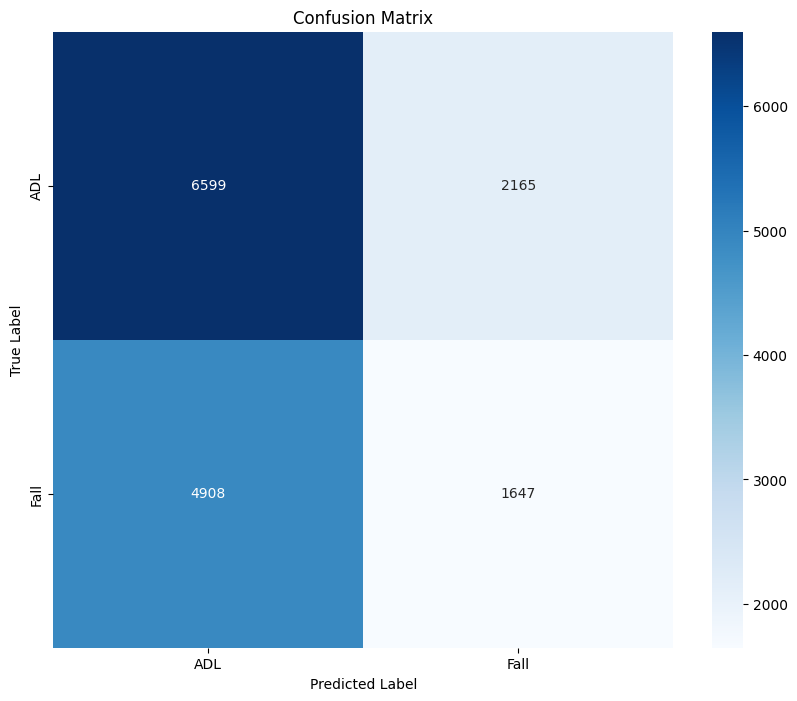

In [163]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
labels = ['ADL', 'Fall']
plt.xticks([0.5, 1.5], labels)
plt.yticks([0.5, 1.5], labels)
plt.show()

In [164]:
print ("classification report")
print(classification_report(true_labels, predictions, 
                          target_names=['ADL', 'Fall']))

classification report
              precision    recall  f1-score   support

         ADL       0.57      0.75      0.65      8764
        Fall       0.43      0.25      0.32      6555

    accuracy                           0.54     15319
   macro avg       0.50      0.50      0.48     15319
weighted avg       0.51      0.54      0.51     15319

